In [1]:
import csv 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import math
import pytz
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from statsmodels.api import OLS
from sklearn.metrics import r2_score, mean_squared_error

# Question 8 

In [25]:
#def function to read and combine data together
def readfile_aggregate(file_list):
    time_list=[]
    num_followers=[]
    num_retweets=[]
    num_replies=[]
    num_mentions=[]
    mentions_ratio=[]
    num_urls=[]
    urls_ratio=[]
    num_hashtags=[]
    hashtags_ratio=[]
    num_favorites=[]
    num_impressions=[]
    num_rank=[]
    for file_name in file_list:
        
        with open(file_name,encoding='utf8') as file:
        #Each line is a tweet info
            data=file.readlines()

        for line in data:
            json_object=json.loads(line)
            time_list.append(json_object['citation_date'])#extract time a tweet is posted by
            num_followers.append(json_object['author']['followers'])#extract number of followers of teh person tweeting
            num_retweets.append(json_object['metrics']['citations']['total'])#extract number of retweets of a tweet
            num_replies.append(json_object['metrics']['citations']['replies'])#extract number of replies
            num_mentions.append(len(json_object['tweet']['entities']['user_mentions']))#extract number of mentions (length of the list)
            mentions_ratio.append(len(json_object['tweet']['entities']['user_mentions'])/len(json_object['tweet']['text']))#extract ration of mentions
            num_urls.append(len(json_object['tweet']['entities']['urls']))#extract number of urls
            urls_ratio.append(len(json_object['tweet']['entities']['urls'])/len(json_object['tweet']['text']))#extract ratio of urls
            num_hashtags.append(len(json_object['tweet']['entities']['hashtags']))#extract number of hastages
            hashtags_ratio.append(len(json_object['tweet']['entities']['hashtags'])/len(json_object['tweet']['text']))#extract ratio of hastages
            num_favorites.append(json_object['tweet']['favorite_count'])
            num_impressions.append(json_object['metrics']['impressions'])
            num_rank.append(json_object['metrics']['ranking_score'])
        file.close()
    date_list=[]
    pst_tz=pytz.timezone('America/Los_Angeles')#time info conversion
    for time in time_list:
        date=datetime.datetime.fromtimestamp(time,pst_tz).replace(tzinfo=None)
        date_list.append(date)#save converted time into a new list
    date_df=pd.DataFrame(date_list,columns=['Date'])#generate a dataframe based on date
    date_df=date_df.set_index(date_df['Date'])#set a date string as index
    #print(date_df)
    date_df.drop(['Date'],'columns',inplace=True)#discard the second column
    date_df['num_tweets']=1 #initialize a new column and set the column name as num_tweets
    date_df['num_followers']=num_followers
    date_df['num_retweets']=num_retweets
    date_df['num_replies']=num_replies
    date_df['num_mentions']=num_mentions
    date_df['num_urls']=num_urls
    date_df['num_hashtags']=num_hashtags
    date_df['num_favorites']=num_favorites
    date_df['num_impressions']=num_impressions
    date_df['num_rank']=num_rank
    
    return date_df


def feature_extraction(date_df,time_period):
    feature_map=date_df.resample(time_period).sum()#total number of tweets, total num_followers, total num_retweets, replies, mentions, urls, hashtags
    #date_df['mentions_ratio']=mentions_ratio
    #date_df['urls_ratio']=urls_ratio
    #date_df['hashtags_ratio']=hashtags_ratio
    feature_map['max_followers']=date_df['num_followers'].resample(time_period).max()#pick maximum num of followers and resample
    feature_map['max_replies']=date_df['num_replies'].resample(time_period).max()
    feature_map['max_mentions']=date_df['num_mentions'].resample(time_period).max()
    feature_map['max_urls']=date_df['num_urls'].resample(time_period).max()
    feature_map['max_hashtags']=date_df['num_hashtags'].resample(time_period).max()
    #feature_map['mentions_ratio']=date_df['mentions_ratio'].resample('H').mean()
    #feature_map['urls_ratio']=date_df['urls_ratio'].resample('H').mean()
    #feature_map['hashtags_ratio']=date_df['hashtags_ratio'].resample('H').mean()
    feature_map['max_favorites']=date_df['num_favorites'].resample(time_period).max()
    feature_map['max_impressions']=date_df['num_impressions'].resample(time_period).max()
    feature_map['max_rank']=date_df['num_rank'].resample(time_period).max()
    feature_map['time']=feature_map.index.hour#extract hour index from 0 to 23
    return feature_map

def divide_three(date_df):
    start_time='2015-02-01 08:00:00'
    end_time='2015-02-01 20:00:00'
    #the first part
    feature_map_first=feature_extraction(date_df,'H')
    feature_map_first=feature_map_first.iloc[feature_map_first.index<start_time,:]
    #the second part
    feature_map_second=feature_extraction(date_df,'5T')
    feature_map_second=feature_map_second.iloc[feature_map_second.index<=end_time,:]
    feature_map_second=feature_map_second.iloc[feature_map_second.index>=start_time,:]
    #the third part
    feature_map_third=feature_extraction(date_df,'H')
    feature_map_third=feature_map_third.iloc[feature_map_third.index>end_time,:]
    
    return feature_map_first, feature_map_second, feature_map_third

In [3]:
file_list=['tweets_#gohawks.txt','tweets_#gopatriots.txt','tweets_#nfl.txt','tweets_#patriots.txt','tweets_#sb49.txt','tweets_#superbowl.txt']
date_df_agg=readfile_aggregate(file_list)


In [15]:
feature_map_all=feature_extraction(date_df_agg,'H')
#Train Label split
X_train=feature_map_all.iloc[:-1]
Y_train=feature_map_all['num_tweets'][1:]
X_train=np.nan_to_num(X_train)
Y_train=np.nan_to_num(Y_train)


# Random Forest

In [16]:
def rf_evaluation(X,Y, maxdep,maxfeat,minsamleaf,minsamsplit,n):
    kf=KFold(5,shuffle=True)
    MSE=[]
    for train,test in kf.split(X):
        rf=RandomForestRegressor(max_depth=maxdep,max_features=maxfeat,min_samples_leaf=minsamleaf,min_samples_split=minsamsplit,n_estimators=n)
        X_train=X[train]
        Y_train=Y[train]
        X_val=X[test]
        Y_val=Y[test]
        mdl=rf.fit(X_train,Y_train)
        Y_pred=mdl.predict(X_val)
        MSE_sub=mean_squared_error(Y_val,Y_pred)
        MSE.append(MSE_sub)
    MSE_ave=np.mean(MSE)
    print('The average MSE for validation is {}'.format(MSE_ave))
    return MSE_ave

When the max depth is 10
The average MSE for validation is 249902536.43776923
When the max depth is 30
The average MSE for validation is 150666808.93087378
When the max depth is 50
The average MSE for validation is 180331934.68920437
When the max depth is 70
The average MSE for validation is 164423966.1746883
When the max depth is 200
The average MSE for validation is 194381595.1570601
When the max depth is None
The average MSE for validation is 175061829.25792527


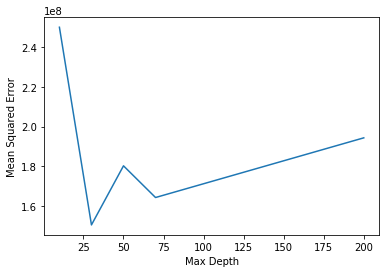

In [28]:
#max_depth
max_depth=[10,30,50,70,200,None]
MSE_overall=[]
for mdp in max_depth:
    print('When the max depth is {}'.format(mdp))
    MSE=rf_evaluation(X_train,Y_train,mdp,'auto',1,2,200)
    MSE_overall.append(MSE)
plt.plot(max_depth,MSE_overall)
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.show()

When the max features is auto
The average MSE for validation is 153909309.7624193
When the max features is sqrt
The average MSE for validation is 210016552.30272716


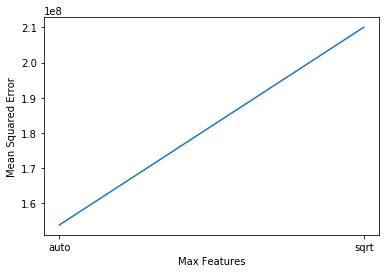

In [29]:
#max_features
max_features=['auto','sqrt']
MSE_overall=[]
for mfe in max_features:
    print('When the max features is {}'.format(mfe))
    MSE=rf_evaluation(X_train,Y_train,30,mfe,1,2,200)
    MSE_overall.append(MSE)
plt.plot(['auto','sqrt'],MSE_overall)
plt.xlabel('Max Features')
plt.ylabel('Mean Squared Error')
plt.show()

When the min_samples_leaf is 1
The average MSE for validation is 205289442.24445096
When the min_samples_leaf is 2
The average MSE for validation is 202268923.32707596
When the min_samples_leaf is 3
The average MSE for validation is 243155139.8324154
When the min_samples_leaf is 4
The average MSE for validation is 254857272.54046392


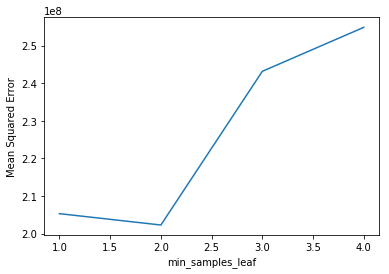

In [30]:
#min_samples_leaf
min_samples_leaf=[1,2,3,4]
MSE_overall=[]
for mas in min_samples_leaf:
    print('When the min_samples_leaf is {}'.format(mas))
    MSE=rf_evaluation(X_train,Y_train,30,'auto',mas,2,200)
    MSE_overall.append(MSE)
plt.plot(min_samples_leaf,MSE_overall)
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

When the min_samples_split is 2
The average MSE for validation is 268994837.8128369
When the min_samples_split is 5
The average MSE for validation is 213443936.38379714
When the min_samples_split is 10
The average MSE for validation is 225888000.93560523


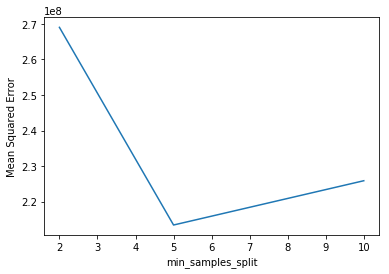

In [32]:
#min_samples_split
min_samples_split=[2,5,10]
MSE_overall=[]
for masp in min_samples_split:
    print('When the min_samples_split is {}'.format(masp))
    MSE=rf_evaluation(X_train,Y_train,30,'auto',2,masp,200)
    MSE_overall.append(MSE)
plt.plot(min_samples_split,MSE_overall)
plt.xlabel('min_samples_split')
plt.ylabel('Mean Squared Error')
plt.show()

When the n_estimators is 200
The average MSE for validation is 244752285.74813634
When the n_estimators is 400
The average MSE for validation is 198631549.6116405
When the n_estimators is 600
The average MSE for validation is 193111548.30627638
When the n_estimators is 800
The average MSE for validation is 241476522.0278334
When the n_estimators is 1000
The average MSE for validation is 200965914.0021494
When the n_estimators is 1200
The average MSE for validation is 186287648.923764
When the n_estimators is 1400
The average MSE for validation is 253304579.97093183
When the n_estimators is 1600
The average MSE for validation is 177102484.66480333
When the n_estimators is 1800
The average MSE for validation is 243432547.83523327
When the n_estimators is 2000
The average MSE for validation is 167284169.9120497


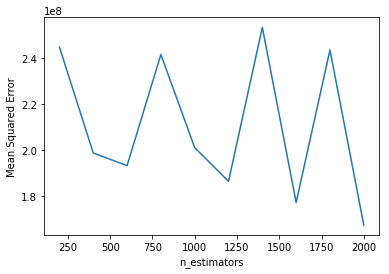

In [33]:
#n_estimator
n_estimators=[200,400,600,800,1000,1200,1400,1600,1800,2000]
MSE_overall=[]
for nest in n_estimators:
    print('When the n_estimators is {}'.format(nest))
    MSE=rf_evaluation(X_train,Y_train,30,'auto',2,5,nest)
    MSE_overall.append(MSE)
plt.plot(n_estimators,MSE_overall)
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.show()

In [38]:
#best estimator from random forest
print('The best configuration obtained from greedy search ')
MSE=rf_evaluation(X_train,Y_train,30,'auto',1,2,200)



The best configuration obtained from greedy search 
The average MSE for validation is 194155766.186244


# Gradient Boosting

In [39]:
#gradientboostingregressor
def gb_evaluation(X,Y, maxdep,maxfeat,minsamleaf,minsamsplit,n):
    kf=KFold(5,shuffle=True)
    MSE=[]
    for train,test in kf.split(X):
        gb=GradientBoostingRegressor(max_depth=maxdep,max_features=maxfeat,min_samples_leaf=minsamleaf,min_samples_split=minsamsplit,n_estimators=n)
        X_train=X[train]
        Y_train=Y[train]
        X_val=X[test]
        Y_val=Y[test]
        mdl=gb.fit(X_train,Y_train)
        Y_pred=mdl.predict(X_val)
        MSE_sub=mean_squared_error(Y_val,Y_pred)
        MSE.append(MSE_sub)
    MSE_ave=np.mean(MSE)
    print('The average MSE for validation is {}'.format(MSE_ave))
    return MSE_ave

When the max depth is 10
The average MSE for validation is 347191791.7071568
When the max depth is 30
The average MSE for validation is 175296299.79292715
When the max depth is 50
The average MSE for validation is 155311126.49686748
When the max depth is 70
The average MSE for validation is 228197454.99987245
When the max depth is 200
The average MSE for validation is 359758929.5747094
When the max depth is None
The average MSE for validation is 199474200.6893515


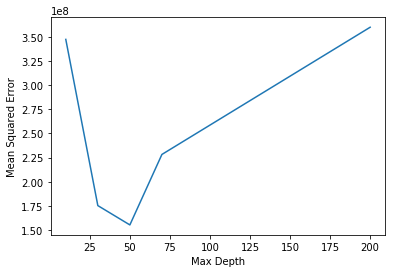

In [40]:
#max_depth
max_depth=[10,30,50,70,200,None]
MSE_overall=[]
for mdp in max_depth:
    print('When the max depth is {}'.format(mdp))
    MSE=gb_evaluation(X_train,Y_train,mdp,'auto',1,2,200)
    MSE_overall.append(MSE)
plt.plot(max_depth,MSE_overall)
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.show()

When the max features is auto
The average MSE for validation is 275550547.3983381
When the max features is sqrt
The average MSE for validation is 270026740.2577664


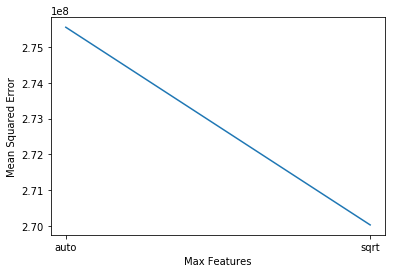

In [41]:
#max_features
max_features=['auto','sqrt']
MSE_overall=[]
for mfe in max_features:
    print('When the max features is {}'.format(mfe))
    MSE=gb_evaluation(X_train,Y_train,50,mfe,1,2,200)
    MSE_overall.append(MSE)
plt.plot(['auto','sqrt'],MSE_overall)
plt.xlabel('Max Features')
plt.ylabel('Mean Squared Error')
plt.show()

When the min_samples_leaf is 1
The average MSE for validation is 259238959.70243064
When the min_samples_leaf is 2
The average MSE for validation is 282976525.5385058
When the min_samples_leaf is 3
The average MSE for validation is 262798131.01316482
When the min_samples_leaf is 4
The average MSE for validation is 262959362.3901218


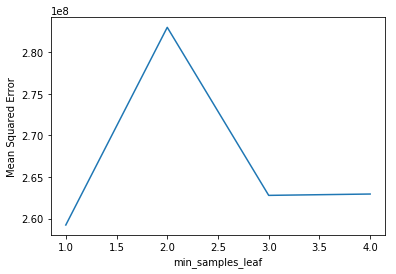

In [42]:
#min_samples_leaf
min_samples_leaf=[1,2,3,4]
MSE_overall=[]
for mas in min_samples_leaf:
    print('When the min_samples_leaf is {}'.format(mas))
    MSE=gb_evaluation(X_train,Y_train,50,'sqrt',mas,2,200)
    MSE_overall.append(MSE)
plt.plot(min_samples_leaf,MSE_overall)
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

When the min_samples_split is 2
The average MSE for validation is 205875633.4070326
When the min_samples_split is 5
The average MSE for validation is 245734131.04663825
When the min_samples_split is 10
The average MSE for validation is 377096896.3761176


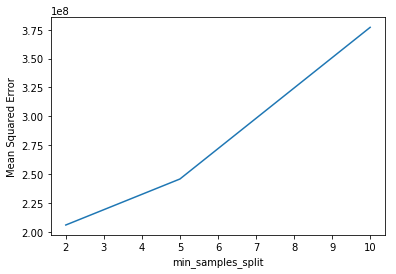

In [43]:
#min_samples_split
min_samples_split=[2,5,10]
MSE_overall=[]
for masp in min_samples_split:
    print('When the min_samples_split is {}'.format(masp))
    MSE=gb_evaluation(X_train,Y_train,50,'sqrt',1,masp,200)
    MSE_overall.append(MSE)
plt.plot(min_samples_split,MSE_overall)
plt.xlabel('min_samples_split')
plt.ylabel('Mean Squared Error')
plt.show()

When the n_estimators is 200
The average MSE for validation is 219532886.95706186
When the n_estimators is 400
The average MSE for validation is 231162465.04653144
When the n_estimators is 600
The average MSE for validation is 273342233.12782824
When the n_estimators is 800
The average MSE for validation is 250708666.850072
When the n_estimators is 1000
The average MSE for validation is 195825890.4003072
When the n_estimators is 1200
The average MSE for validation is 258716579.73113766
When the n_estimators is 1400
The average MSE for validation is 252806098.81178704
When the n_estimators is 1600
The average MSE for validation is 182602607.09783995
When the n_estimators is 1800
The average MSE for validation is 252287628.58900443
When the n_estimators is 2000
The average MSE for validation is 211231071.9637249


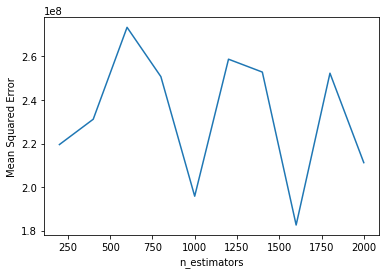

In [44]:
#n_estimator
n_estimators=[200,400,600,800,1000,1200,1400,1600,1800,2000]
MSE_overall=[]
for nest in n_estimators:
    print('When the n_estimators is {}'.format(nest))
    MSE=gb_evaluation(X_train,Y_train,50,'sqrt',1,2,nest)
    MSE_overall.append(MSE)
plt.plot(n_estimators,MSE_overall)
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.show()

In [55]:
#best estimator from gradient boosting regressor
MSE=gb_evaluation(X_train,Y_train,70,'auto',3,2,1000)
print('The best configuration obtained from greedy search ')
print('MSE is {}'.format(MSE))

The average MSE for validation is 211533040.92344654
The best configuration obtained from greedy search 
MSE is 211533040.92344654


# Question 9

In [56]:
#OLS on entire dataset
def ols_entire(X,Y):
    kf=KFold(5,shuffle=True)
    MSE=[]
    for train,test in kf.split(X):
        X_train=X[train]
        Y_train=Y[train]
        X_val=X[test]
        Y_val=Y[test]
        model=OLS(Y_train,X_train)
        #model fitting
        mdl=model.fit()
        Y_pred=mdl.predict(X_val)
        mse=mean_squared_error(Y_val,Y_pred)#get mse score
    MSE.append(mse)
    mse_ave=np.mean(MSE)
    return mse_ave
    

In [70]:
mse=ols_entire(X_train,Y_train)
print('The MSE of OLS on entire dataset is {}'.format(mse))

The MSE of OLS on entire dataset is 1149683360.496773


# Question 10

In [71]:
feature_map_all_first,feature_map_all_second,feature_map_all_third=divide_three(date_df_agg)

In [72]:
#First Segment
#Train Label split
X_train=feature_map_all_first.iloc[:-1]
Y_train=feature_map_all_first['num_tweets'][1:]
X_train=np.nan_to_num(X_train)
Y_train=np.nan_to_num(Y_train)

When the max depth is 10
The average MSE for validation is 7963416.693226071
When the max depth is 30
The average MSE for validation is 10255609.036981251
When the max depth is 50
The average MSE for validation is 5895004.497295947
When the max depth is 70
The average MSE for validation is 5240077.49417533
When the max depth is 200
The average MSE for validation is 5936415.5620597955
When the max depth is None
The average MSE for validation is 10714822.930836355


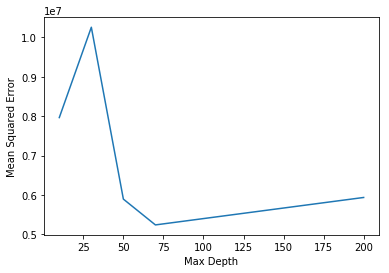

In [73]:
#max_depth
max_depth=[10,30,50,70,200,None]
MSE_overall=[]
for mdp in max_depth:
    print('When the max depth is {}'.format(mdp))
    MSE=gb_evaluation(X_train,Y_train,mdp,'auto',1,2,200)
    MSE_overall.append(MSE)
plt.plot(max_depth,MSE_overall)
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.show()

When the max features is auto
The average MSE for validation is 5786905.018597701
When the max features is sqrt
The average MSE for validation is 6141543.897162158


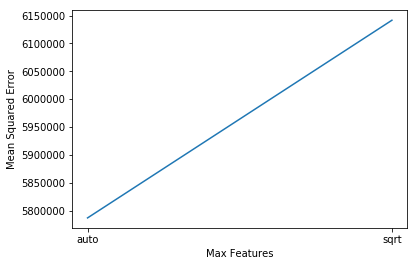

In [74]:
#max_features
max_features=['auto','sqrt']
MSE_overall=[]
for mfe in max_features:
    print('When the max features is {}'.format(mfe))
    MSE=gb_evaluation(X_train,Y_train,70,mfe,1,2,200)
    MSE_overall.append(MSE)
plt.plot(['auto','sqrt'],MSE_overall)
plt.xlabel('Max Features')
plt.ylabel('Mean Squared Error')
plt.show()

When the min_samples_leaf is 1
The average MSE for validation is 5219550.61034283
When the min_samples_leaf is 2
The average MSE for validation is 7137716.335782668
When the min_samples_leaf is 3
The average MSE for validation is 6419564.483018195
When the min_samples_leaf is 4
The average MSE for validation is 7284705.029339989


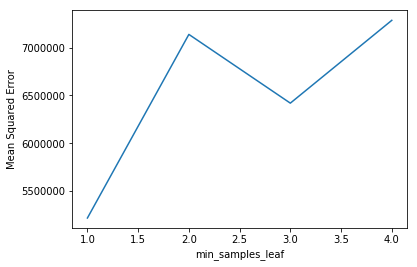

In [75]:
#min_samples_leaf
min_samples_leaf=[1,2,3,4]
MSE_overall=[]
for mas in min_samples_leaf:
    print('When the min_samples_leaf is {}'.format(mas))
    MSE=gb_evaluation(X_train,Y_train,70,'auto',mas,2,200)
    MSE_overall.append(MSE)
plt.plot(min_samples_leaf,MSE_overall)
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

When the min_samples_split is 2
The average MSE for validation is 5244524.372067235
When the min_samples_split is 5
The average MSE for validation is 7652486.351352135
When the min_samples_split is 10
The average MSE for validation is 4521918.96135295


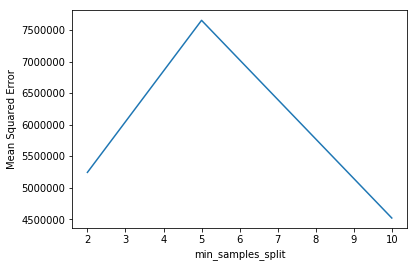

In [76]:
#min_samples_split
min_samples_split=[2,5,10]
MSE_overall=[]
for masp in min_samples_split:
    print('When the min_samples_split is {}'.format(masp))
    MSE=gb_evaluation(X_train,Y_train,50,'auto',1,masp,200)
    MSE_overall.append(MSE)
plt.plot(min_samples_split,MSE_overall)
plt.xlabel('min_samples_split')
plt.ylabel('Mean Squared Error')
plt.show()

When the n_estimators is 200
The average MSE for validation is 7236953.847593407
When the n_estimators is 400
The average MSE for validation is 5638616.695578206
When the n_estimators is 600
The average MSE for validation is 6783151.16349152
When the n_estimators is 800
The average MSE for validation is 7578111.438794635
When the n_estimators is 1000
The average MSE for validation is 7173875.122044636
When the n_estimators is 1200
The average MSE for validation is 7735736.675631858
When the n_estimators is 1400
The average MSE for validation is 6346587.22219191
When the n_estimators is 1600
The average MSE for validation is 6588344.314476392
When the n_estimators is 1800
The average MSE for validation is 8044045.643059623
When the n_estimators is 2000
The average MSE for validation is 8652547.776288282


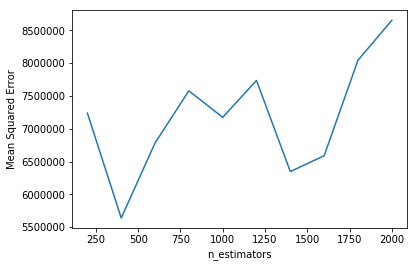

In [77]:
#n_estimator
n_estimators=[200,400,600,800,1000,1200,1400,1600,1800,2000]
MSE_overall=[]
for nest in n_estimators:
    print('When the n_estimators is {}'.format(nest))
    MSE=gb_evaluation(X_train,Y_train,70,'auto',1,10,nest)
    MSE_overall.append(MSE)
plt.plot(n_estimators,MSE_overall)
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.show()

In [82]:
#best estimator from gradient boosting regressor
MSE=gb_evaluation(X_train,Y_train,70,'sqrt',1,10,1000)
print('The best configuration obtained from greedy search ')
print('MSE is {}'.format(MSE))

The average MSE for validation is 3747917.3884718306
The best configuration obtained from greedy search 
MSE is 3747917.3884718306


In [83]:
#Second Segment
#Train Label split
X_train=feature_map_all_second.iloc[:-1]
Y_train=feature_map_all_second['num_tweets'][1:]
X_train=np.nan_to_num(X_train)
Y_train=np.nan_to_num(Y_train)

When the max depth is 10
The average MSE for validation is 47096724.103768155
When the max depth is 30
The average MSE for validation is 50905112.47090868
When the max depth is 50
The average MSE for validation is 42856932.90420825
When the max depth is 70
The average MSE for validation is 42264006.81275883
When the max depth is 200
The average MSE for validation is 46426744.22024664
When the max depth is None
The average MSE for validation is 43726614.991379894


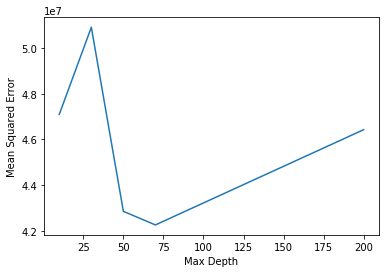

In [84]:
#max_depth
max_depth=[10,30,50,70,200,None]
MSE_overall=[]
for mdp in max_depth:
    print('When the max depth is {}'.format(mdp))
    MSE=gb_evaluation(X_train,Y_train,mdp,'auto',1,2,200)
    MSE_overall.append(MSE)
plt.plot(max_depth,MSE_overall)
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.show()

When the max features is auto
The average MSE for validation is 44597101.614164144
When the max features is sqrt
The average MSE for validation is 28306704.377608918


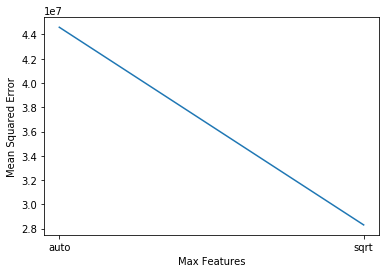

In [85]:
#max_features
max_features=['auto','sqrt']
MSE_overall=[]
for mfe in max_features:
    print('When the max features is {}'.format(mfe))
    MSE=gb_evaluation(X_train,Y_train,70,mfe,1,2,200)
    MSE_overall.append(MSE)
plt.plot(['auto','sqrt'],MSE_overall)
plt.xlabel('Max Features')
plt.ylabel('Mean Squared Error')
plt.show()

When the min_samples_leaf is 1
The average MSE for validation is 27618413.108094275
When the min_samples_leaf is 2
The average MSE for validation is 32302936.564809192
When the min_samples_leaf is 3
The average MSE for validation is 28171415.33886106
When the min_samples_leaf is 4
The average MSE for validation is 27473249.5119053


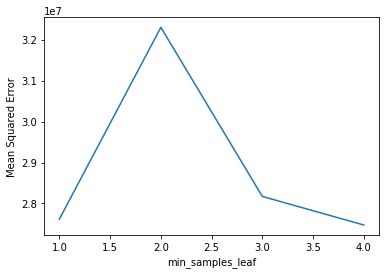

In [86]:
#min_samples_leaf
min_samples_leaf=[1,2,3,4]
MSE_overall=[]
for mas in min_samples_leaf:
    print('When the min_samples_leaf is {}'.format(mas))
    MSE=gb_evaluation(X_train,Y_train,70,'sqrt',mas,2,200)
    MSE_overall.append(MSE)
plt.plot(min_samples_leaf,MSE_overall)
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

When the min_samples_split is 2
The average MSE for validation is 30716871.64306299
When the min_samples_split is 5
The average MSE for validation is 26946524.653417177
When the min_samples_split is 10
The average MSE for validation is 28572497.70912879


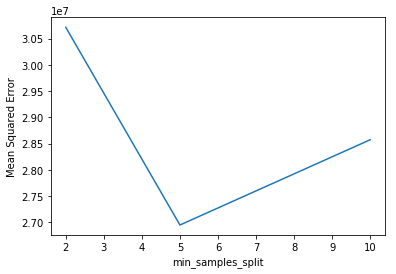

In [87]:
#min_samples_split
min_samples_split=[2,5,10]
MSE_overall=[]
for masp in min_samples_split:
    print('When the min_samples_split is {}'.format(masp))
    MSE=gb_evaluation(X_train,Y_train,70,'sqrt',1,masp,200)
    MSE_overall.append(MSE)
plt.plot(min_samples_split,MSE_overall)
plt.xlabel('min_samples_split')
plt.ylabel('Mean Squared Error')
plt.show()

When the n_estimators is 200
The average MSE for validation is 25739301.738742374
When the n_estimators is 400
The average MSE for validation is 29926551.557706725
When the n_estimators is 600
The average MSE for validation is 25371297.132431135
When the n_estimators is 800
The average MSE for validation is 29090926.06688128
When the n_estimators is 1000
The average MSE for validation is 31042162.130812645
When the n_estimators is 1200
The average MSE for validation is 24489649.664948504
When the n_estimators is 1400
The average MSE for validation is 26442116.49001781
When the n_estimators is 1600
The average MSE for validation is 26846111.577640504
When the n_estimators is 1800
The average MSE for validation is 25267200.120246373
When the n_estimators is 2000
The average MSE for validation is 24333457.017131764


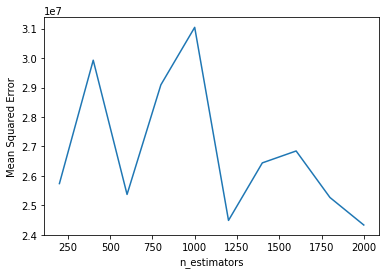

In [88]:
#n_estimator
n_estimators=[200,400,600,800,1000,1200,1400,1600,1800,2000]
MSE_overall=[]
for nest in n_estimators:
    print('When the n_estimators is {}'.format(nest))
    MSE=gb_evaluation(X_train,Y_train,50,'sqrt',1,5,nest)
    MSE_overall.append(MSE)
plt.plot(n_estimators,MSE_overall)
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.show()

In [89]:
#best estimator from gradient boosting regressor
MSE=gb_evaluation(X_train,Y_train,50,'sqrt',1,5,1200)
print('The best configuration obtained from greedy search ')
print('MSE is {}'.format(MSE))

The average MSE for validation is 26513343.832522247
The best configuration obtained from greedy search 
MSE is 26513343.832522247


In [90]:
#Third Segment
#Train Label split
X_train=feature_map_all_third.iloc[:-1]
Y_train=feature_map_all_third['num_tweets'][1:]
X_train=np.nan_to_num(X_train)
Y_train=np.nan_to_num(Y_train)

When the max depth is 10
The average MSE for validation is 512339.5937559436
When the max depth is 30
The average MSE for validation is 711492.1469506159
When the max depth is 50
The average MSE for validation is 680372.3896826748
When the max depth is 70
The average MSE for validation is 281176.0582504337
When the max depth is 200
The average MSE for validation is 506187.3014958134
When the max depth is None
The average MSE for validation is 605145.7549745243


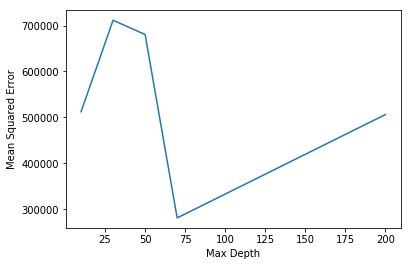

In [91]:
#max_depth
max_depth=[10,30,50,70,200,None]
MSE_overall=[]
for mdp in max_depth:
    print('When the max depth is {}'.format(mdp))
    MSE=gb_evaluation(X_train,Y_train,mdp,'auto',1,2,200)
    MSE_overall.append(MSE)
plt.plot(max_depth,MSE_overall)
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.show()

When the max features is auto
The average MSE for validation is 395282.2425669791
When the max features is sqrt
The average MSE for validation is 466180.768972913


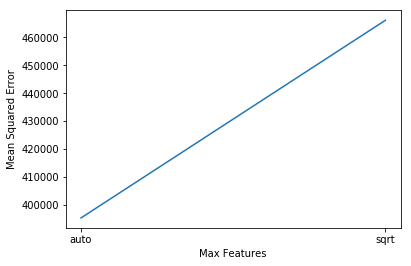

In [92]:
#max_features
max_features=['auto','sqrt']
MSE_overall=[]
for mfe in max_features:
    print('When the max features is {}'.format(mfe))
    MSE=gb_evaluation(X_train,Y_train,70,mfe,1,2,200)
    MSE_overall.append(MSE)
plt.plot(['auto','sqrt'],MSE_overall)
plt.xlabel('Max Features')
plt.ylabel('Mean Squared Error')
plt.show()

When the min_samples_leaf is 1
The average MSE for validation is 581788.9718095952
When the min_samples_leaf is 2
The average MSE for validation is 462705.0534437193
When the min_samples_leaf is 3
The average MSE for validation is 467350.82981094875
When the min_samples_leaf is 4
The average MSE for validation is 321747.97727838217


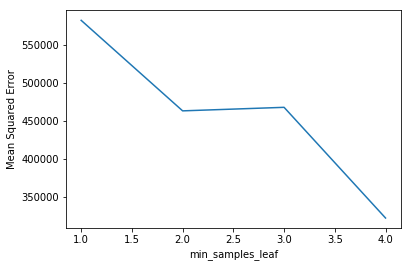

In [93]:
#min_samples_leaf
min_samples_leaf=[1,2,3,4]
MSE_overall=[]
for mas in min_samples_leaf:
    print('When the min_samples_leaf is {}'.format(mas))
    MSE=gb_evaluation(X_train,Y_train,70,'auto',mas,2,200)
    MSE_overall.append(MSE)
plt.plot(min_samples_leaf,MSE_overall)
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean Squared Error')
plt.show()

When the min_samples_split is 2
The average MSE for validation is 378125.6576255064
When the min_samples_split is 5
The average MSE for validation is 338204.72938400425
When the min_samples_split is 10
The average MSE for validation is 531482.204645355


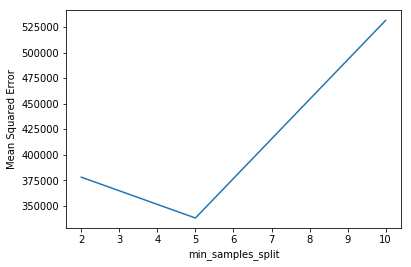

In [94]:
#min_samples_split
min_samples_split=[2,5,10]
MSE_overall=[]
for masp in min_samples_split:
    print('When the min_samples_split is {}'.format(masp))
    MSE=gb_evaluation(X_train,Y_train,70,'auto',4,masp,200)
    MSE_overall.append(MSE)
plt.plot(min_samples_split,MSE_overall)
plt.xlabel('min_samples_split')
plt.ylabel('Mean Squared Error')
plt.show()

When the n_estimators is 200
The average MSE for validation is 346319.3837081745
When the n_estimators is 400
The average MSE for validation is 313024.2340085097
When the n_estimators is 600
The average MSE for validation is 365525.3692268404
When the n_estimators is 800
The average MSE for validation is 484669.46518872556
When the n_estimators is 1000
The average MSE for validation is 411377.0191174775
When the n_estimators is 1200
The average MSE for validation is 352785.1430021476
When the n_estimators is 1400
The average MSE for validation is 414568.2434287067
When the n_estimators is 1600
The average MSE for validation is 401926.3846678394
When the n_estimators is 1800
The average MSE for validation is 384835.04138742946
When the n_estimators is 2000
The average MSE for validation is 430339.4706277147


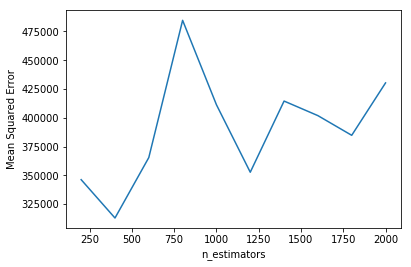

In [95]:
#n_estimator
n_estimators=[200,400,600,800,1000,1200,1400,1600,1800,2000]
MSE_overall=[]
for nest in n_estimators:
    print('When the n_estimators is {}'.format(nest))
    MSE=gb_evaluation(X_train,Y_train,70,'auto',4,5,nest)
    MSE_overall.append(MSE)
plt.plot(n_estimators,MSE_overall)
plt.xlabel('n_estimators')
plt.ylabel('Mean Squared Error')
plt.show()

In [100]:
#best estimator from gradient boosting regressor
MSE=gb_evaluation(X_train,Y_train,70,'auto',4,5,400)
print('The best configuration obtained from greedy search ')
print('MSE is {}'.format(MSE))

The average MSE for validation is 347890.7881714591
The best configuration obtained from greedy search 
MSE is 347890.7881714591
